In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [289]:
from nilearn import datasets
atlas = datasets.fetch_atlas_msdl()
atlas_filename = atlas['maps']
labels = atlas['labels']
coords = atlas['region_coords']
print(labels, len(labels))

['L Aud', 'R Aud', 'Striate', 'L DMN', 'Med DMN', 'Front DMN', 'R DMN', 'Occ post', 'Motor', 'R DLPFC', 'R Front pol', 'R Par', 'R Post Temp', 'Basal', 'L Par', 'L DLPFC', 'L Front pol', 'L IPS', 'R IPS', 'L LOC', 'Vis', 'R LOC', 'D ACC', 'V ACC', 'R A Ins', 'L STS', 'R STS', 'L TPJ', 'Broca', 'Sup Front S', 'R TPJ', 'R Pars Op', 'Cereb', 'Dors PCC', 'L Ins', 'Cing', 'R Ins', 'L Ant IPS', 'R Ant IPS'] 39


In [2]:
data = pd.read_csv('./datasets/func_conn.csv')
data.head()

,file,ID,target,Sex,L Aud-R Aud,L Aud-Striate,R Aud-Striate,L Aud-L DMN,R Aud-L DMN,Striate-L DMN,...,Broca-R Ant IPS,Sup Front S-R Ant IPS,R TPJ-R Ant IPS,R Pars Op-R Ant IPS,Cereb-R Ant IPS,Dors PCC-R Ant IPS,L Ins-R Ant IPS,Cing-R Ant IPS,R Ins-R Ant IPS,L Ant IPS-R Ant IPS
0,morphometry_A00007409,A00007409,No_Known_Disorder,male,0.852745,0.472408,0.438451,-0.151586,-0.175817,-0.088072,...,0.157520,0.111554,0.024794,0.074087,0.083605,0.332223,0.299678,0.378165,0.238186,0.633913
1,morphometry_A00031597,A00031597,Schizophrenia_Strict,male,0.748457,0.532091,0.617542,0.090878,0.043540,-0.036074,...,0.374588,0.340460,0.342494,0.249617,0.382124,0.604362,0.168657,0.284299,0.183674,0.626664
2,morphometry_A00022500,A00022500,Schizophrenia_Strict,female,0.592125,0.036093,0.133537,0.082847,0.179051,0.314248,...,-0.253343,-0.049419,0.103218,-0.098405,-0.106043,0.359292,-0.283070,0.194902,-0.112684,0.582636
3,morphometry_A00024953,A00024953,Schizophrenia_Strict,male,0.780837,0.354871,0.420179,0.144601,0.208352,0.168114,...,0.190040,-0.012739,-0.038590,0.150418,0.043712,0.165942,-0.003737,0.316817,-0.003129,0.633039
4,morphometry_A00001251,A00001251,Schizophrenia_Strict,male,0.447026,-0.024045,0.432331,-0.247530,0.113947,0.412405,...,-0.240672,0.271395,-0.054881,0.044233,0.063376,0.387130,0.145573,0.396055,0.112810,0.532662


In [291]:
# connectivity_mat = np.zeros((len(vertices_names), len(vertices_names)))
names_map = {val: i for i, val in enumerate(labels)}

In [293]:
names_map

{'L Aud': 0,
 'R Aud': 1,
 'Striate': 2,
 'L DMN': 3,
 'Med DMN': 4,
 'Front DMN': 5,
 'R DMN': 6,
 'Occ post': 7,
 'Motor': 8,
 'R DLPFC': 9,
 'R Front pol': 10,
 'R Par': 11,
 'R Post Temp': 12,
 'Basal': 13,
 'L Par': 14,
 'L DLPFC': 15,
 'L Front pol': 16,
 'L IPS': 17,
 'R IPS': 18,
 'L LOC': 19,
 'Vis': 20,
 'R LOC': 21,
 'D ACC': 22,
 'V ACC': 23,
 'R A Ins': 24,
 'L STS': 25,
 'R STS': 26,
 'L TPJ': 27,
 'Broca': 28,
 'Sup Front S': 29,
 'R TPJ': 30,
 'R Pars Op': 31,
 'Cereb': 32,
 'Dors PCC': 33,
 'L Ins': 34,
 'Cing': 35,
 'R Ins': 36,
 'L Ant IPS': 37,
 'R Ant IPS': 38}

In [8]:
def get_adjmat(patient):
    connectivity_mat = np.zeros((len(vertices_names), len(vertices_names)))
    for i, name1 in enumerate(names_map.keys()):
        for name2 in list(names_map.keys())[(i+1):]: # skipping past and skipping itself
            col_name = f'{name1}-{name2}' if f'{name1}-{name2}' in patient.columns else None
            col_name = f'{name2}-{name1}' if (f'{name2}-{name1}' in patient.columns and col_name is None) else col_name
            if col_name is not None:
                connectivity_mat[names_map[name1]][names_map[name2]] = patient[col_name]
                connectivity_mat[names_map[name2]][names_map[name1]] = patient[col_name]
                
    return connectivity_mat

In [7]:
patient_0 = pd.DataFrame(data.iloc[0]).T

In [9]:
connectivity_mat = get_adjmat(patient_0)

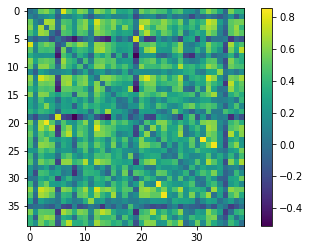

In [34]:
plt.imshow(connectivity_mat)
plt.colorbar()

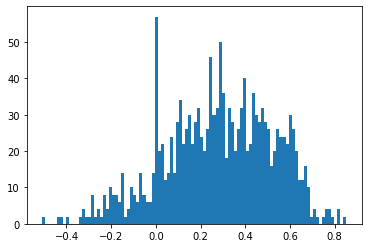

In [38]:
plt.hist(connectivity_mat.reshape(-1), bins=100);

In [11]:
with open('./datasets/Schiza.txt', 'w') as f:
    for name in names_map.values():
        f.write(f'0\t0\t0\t{name}\t0\tregion_name\n')
    

In [12]:
labels = data['target']

In [13]:
connectivity_mat.shape

(39, 39)

In [14]:
np.unique(labels)

array(['No_Known_Disorder', 'Schizoaffective', 'Schizophrenia_Strict'],
      dtype=object)

In [15]:
data_schizastrict = data.drop(data[data['target'] == 'Schizoaffective'].index, axis='index')

In [16]:
labels_schizastrict = data_schizastrict['target']

In [17]:
labels_bin = [1. if ('Schizo' in l) else 0. for l in labels_schizastrict]

In [18]:
connectivity_data = np.asarray(list([get_adjmat(pd.DataFrame(data_schizastrict.iloc[i]).T) for i in range(data_schizastrict.shape[0])]))


In [19]:
connectivity_data.shape

(152, 39, 39)

In [20]:
from scipy.io import savemat, loadmat

In [21]:
savemat('./datasets/Schiza.mat', {'label': labels_bin, 'dti': connectivity_data.T})

In [22]:
loadmat('./datasets/Schiza.mat')

{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Mon Oct 24 14:17:42 2022',
 '__version__': '1.0',
 '__globals__': [],
 'label': array([[0., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1., 0., 1., 0., 1., 1.,
         0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 1., 1., 1.,
         1., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0.,
         0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0., 1., 0.,
         1., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
         0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0.,
         1., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0.,
         0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 1., 1., 1.,
         0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1.,
         0., 0., 1., 0., 0., 0., 1., 0.]]),
 'dti': array([[[ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.10143047,  0.20409433, -0.0105

In [44]:
!cd ./IBGNN && python main_explainer.py --k_fold_splits=3 --dataset_path=/home/neuro-gnn-project/datasets --dataset_name=Schiza --explain

node atts [[0.0, 0.0, 0.0, 0, 'region_name\n'], [0.0, 0.0, 0.0, 1, 'region_name\n'], [0.0, 0.0, 0.0, 2, 'region_name\n'], [0.0, 0.0, 0.0, 3, 'region_name\n'], [0.0, 0.0, 0.0, 4, 'region_name\n'], [0.0, 0.0, 0.0, 5, 'region_name\n'], [0.0, 0.0, 0.0, 6, 'region_name\n'], [0.0, 0.0, 0.0, 7, 'region_name\n'], [0.0, 0.0, 0.0, 8, 'region_name\n'], [0.0, 0.0, 0.0, 9, 'region_name\n'], [0.0, 0.0, 0.0, 10, 'region_name\n'], [0.0, 0.0, 0.0, 11, 'region_name\n'], [0.0, 0.0, 0.0, 12, 'region_name\n'], [0.0, 0.0, 0.0, 13, 'region_name\n'], [0.0, 0.0, 0.0, 14, 'region_name\n'], [0.0, 0.0, 0.0, 15, 'region_name\n'], [0.0, 0.0, 0.0, 16, 'region_name\n'], [0.0, 0.0, 0.0, 17, 'region_name\n'], [0.0, 0.0, 0.0, 18, 'region_name\n'], [0.0, 0.0, 0.0, 19, 'region_name\n'], [0.0, 0.0, 0.0, 20, 'region_name\n'], [0.0, 0.0, 0.0, 21, 'region_name\n'], [0.0, 0.0, 0.0, 22, 'region_name\n'], [0.0, 0.0, 0.0, 23, 'region_name\n'], [0.0, 0.0, 0.0, 24, 'region_name\n'], [0.0, 0.0, 0.0, 25, 'region_name\n'], [0.0, 0.0, 

(Tuning Train) | Epoch=052, loss=0.4989, 
train_micro=87.50, train_macro=87.30, train_auc=97.60
(Tuning Train) | Epoch=053, loss=0.3597, 
train_micro=96.05, train_macro=96.05, train_auc=97.20
(Tuning Train) | Epoch=054, loss=0.2717, 
train_micro=96.05, train_macro=96.05, train_auc=97.32
(Tuning Train) | Epoch=055, loss=0.2400, 
train_micro=96.05, train_macro=96.05, train_auc=98.15
(Tuning Train) | Epoch=056, loss=0.3388, 
train_micro=92.11, train_macro=92.08, train_auc=95.51
(Tuning Train) | Epoch=057, loss=0.4399, 
train_micro=86.18, train_macro=85.96, train_auc=89.81
(Tuning Train) | Epoch=058, loss=0.2657, 
train_micro=90.13, train_macro=90.06, train_auc=91.73
(Tuning Train) | Epoch=059, loss=0.2723, 
train_micro=89.47, train_macro=89.41, train_auc=92.84
(Tuning Train) | Epoch=060, loss=0.3061, 
train_micro=78.95, train_macro=78.09, train_auc=81.98
(Tuning Train) | Epoch=061, loss=0.5085, 
train_micro=94.08, train_macro=94.07, train_auc=97.37
(Tuning Train) | Epoch=062, loss=0.2320,

**K Fold training, k = 7**

| K Fold | Result |
| --- | --- |
|(K Fold Initial)| avg_acc=61.18 +-  5.30, avg_auc=64.04 +- 5.59, avg_macro=60.12 +- 5.28|
|(K Fold Tuning) | avg_acc=63.82 +-  10.72, avg_auc=67.10 +- 9.96avg_macro=63.38 +- 10.75|

**K Fold training, k = 5**

| K Fold | Result |
| --- | --- |
|(K Fold Initial)| avg_acc=64.68 +-  5.39, avg_auc=66.52 +- 5.30, avg_macro=63.91 +- 5.65|
|(K Fold Tuning) | avg_acc=67.72 +-  3.56, avg_auc=71.08 +- 2.99avg_macro=67.63 +- 3.49|


**K Fold training, k = 3**

| F Fold | Result |
| --- | --- |
|(K Fold Initial)| avg_acc=59.29 +-  10.34, avg_auc=60.47 +- 10.67, avg_macro=58.77 +- 10.39|
|(K Fold Tuning) | avg_acc=61.23 +-  8.65, avg_auc=65.58 +- 11.96avg_macro=60.30 +- 8.16|

**K Fold training, k = 10**

| F Fold | Result |
| --- | --- |
|(K Fold Initial)| avg_acc=61.69 +-  10.11, avg_auc=65.21 +- 13.82, avg_macro=60.31 +- 10.09|
|(K Fold Tuning) | avg_acc=62.38 +-  10.65, avg_auc=64.89 +- 14.24avg_macro=61.62 +- 10.74|

In [228]:
!cd ./IBGNN && python main_explainer.py --train --explain --save_explanation \
 --initial_epochs 200 --tuning_epochs 200 --test_interval 50 \
 --dataset_path=/home/neuro-gnn-project/datasets --dataset_name=Schiza


seed for seed_everything(): 112078
Training 80/20 

/root/anaconda3/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
(Initial Train) | Epoch=000, loss=39.7778, 
train_micro=58.68, train_macro=58.45, train_auc=59.81
(Initial Train) | Epoch=001, loss=22.2418, 
train_micro=60.33, train_macro=60.20, train_auc=60.20
(Initial Train) | Epoch=002, loss=16.6107, 
train_micro=61.16, train_macro=61.15, train_auc=62.42
(Initial Train) | Epoch=003, loss=13.5137, 
train_micro=62.81, train_macro=62.72, train_auc=66.61
(Initial Train) | Epoch=004, loss=10.8599, 
train_micro=60.33, train_macro=60.33, train_auc=61.71
(Initial Train) | Epoch=005, loss=9.4613, 
train_micro=64.46, train_macro=63.98, train_auc=64.68
(Initial Train) | Epoch=006, loss=7.4849, 
train_micro=61.98, train_macro=61.96, train_auc=66.45
(Initial Train) | Epoch=007, loss=6.7575, 
train_micro=61.98, train_macro=61.86, train

(Initial Train) | Epoch=082, loss=0.1052, 
train_micro=92.56, train_macro=92.54, train_auc=96.98
(Initial Train) | Epoch=083, loss=0.0949, 
train_micro=90.91, train_macro=90.79, train_auc=95.59
(Initial Train) | Epoch=084, loss=0.1119, 
train_micro=95.87, train_macro=95.84, train_auc=97.96
(Initial Train) | Epoch=085, loss=0.1608, 
train_micro=90.91, train_macro=90.91, train_auc=96.97
(Initial Train) | Epoch=086, loss=0.1951, 
train_micro=80.17, train_macro=79.86, train_auc=95.74
(Initial Train) | Epoch=087, loss=0.2758, 
train_micro=91.74, train_macro=91.61, train_auc=97.86
(Initial Train) | Epoch=088, loss=0.1081, 
train_micro=95.04, train_macro=95.00, train_auc=97.23
(Initial Train) | Epoch=089, loss=0.1564, 
train_micro=96.69, train_macro=96.69, train_auc=97.75
(Initial Train) | Epoch=090, loss=0.1255, 
train_micro=84.30, train_macro=84.19, train_auc=95.92
(Initial Train) | Epoch=091, loss=0.1967, 
train_micro=91.74, train_macro=91.72, train_auc=94.87
(Initial Train) | Epoch=092, l

(Initial Train) | Epoch=165, loss=0.0000, 
train_micro=100.00, train_macro=100.00, train_auc=100.00
(Initial Train) | Epoch=166, loss=0.0000, 
train_micro=100.00, train_macro=100.00, train_auc=100.00
(Initial Train) | Epoch=167, loss=0.0000, 
train_micro=100.00, train_macro=100.00, train_auc=100.00
(Initial Train) | Epoch=168, loss=0.0000, 
train_micro=100.00, train_macro=100.00, train_auc=100.00
(Initial Train) | Epoch=169, loss=0.0000, 
train_micro=100.00, train_macro=100.00, train_auc=100.00
(Initial Train) | Epoch=170, loss=0.0000, 
train_micro=100.00, train_macro=100.00, train_auc=100.00
(Initial Train) | Epoch=171, loss=0.0000, 
train_micro=100.00, train_macro=100.00, train_auc=100.00
(Initial Train) | Epoch=172, loss=0.0000, 
train_micro=100.00, train_macro=100.00, train_auc=100.00
(Initial Train) | Epoch=173, loss=0.0000, 
train_micro=100.00, train_macro=100.00, train_auc=100.00
(Initial Train) | Epoch=174, loss=0.0000, 
train_micro=100.00, train_macro=100.00, train_auc=100.00


(Tuning Train) | Epoch=039, loss=0.0628, 
train_micro=88.43, train_macro=88.39, train_auc=100.00
(Tuning Train) | Epoch=040, loss=0.0257, 
train_micro=92.56, train_macro=92.43, train_auc=100.00
(Tuning Train) | Epoch=041, loss=0.0107, 
train_micro=96.69, train_macro=96.69, train_auc=100.00
(Tuning Train) | Epoch=042, loss=0.0146, 
train_micro=87.60, train_macro=87.18, train_auc=97.37
(Tuning Train) | Epoch=043, loss=0.0287, 
train_micro=95.87, train_macro=95.87, train_auc=100.00
(Tuning Train) | Epoch=044, loss=0.0096, 
train_micro=98.35, train_macro=98.34, train_auc=100.00
(Tuning Train) | Epoch=045, loss=0.0146, 
train_micro=100.00, train_macro=100.00, train_auc=100.00
(Tuning Train) | Epoch=046, loss=0.0140, 
train_micro=99.17, train_macro=99.17, train_auc=100.00
(Tuning Train) | Epoch=047, loss=0.0003, 
train_micro=96.69, train_macro=96.67, train_auc=99.12
(Tuning Train) | Epoch=048, loss=0.0152, 
train_micro=100.00, train_macro=100.00, train_auc=100.00
(Tuning Train) | Epoch=049, 

(Tuning Train) | Epoch=121, loss=0.0000, 
train_micro=100.00, train_macro=100.00, train_auc=100.00
(Tuning Train) | Epoch=122, loss=0.0000, 
train_micro=100.00, train_macro=100.00, train_auc=100.00
(Tuning Train) | Epoch=123, loss=0.0000, 
train_micro=100.00, train_macro=100.00, train_auc=100.00
(Tuning Train) | Epoch=124, loss=0.0000, 
train_micro=100.00, train_macro=100.00, train_auc=100.00
(Tuning Train) | Epoch=125, loss=0.0000, 
train_micro=100.00, train_macro=100.00, train_auc=100.00
(Tuning Train) | Epoch=126, loss=0.0000, 
train_micro=100.00, train_macro=100.00, train_auc=100.00
(Tuning Train) | Epoch=127, loss=0.0000, 
train_micro=100.00, train_macro=100.00, train_auc=100.00
(Tuning Train) | Epoch=128, loss=0.0000, 
train_micro=100.00, train_macro=100.00, train_auc=100.00
(Tuning Train) | Epoch=129, loss=0.0000, 
train_micro=100.00, train_macro=100.00, train_auc=100.00
(Tuning Train) | Epoch=130, loss=0.0000, 
train_micro=100.00, train_macro=100.00, train_auc=100.00
(Tuning Tr

In [229]:
general_edge_mask = torch.load('IBGNN/edge_mask.pt')

In [230]:
for i in range(general_edge_mask.shape[0]):
    general_edge_mask[i][i] = 0.0

Text(0.5, 1.0, 'edge mask * connectivity thresholded')

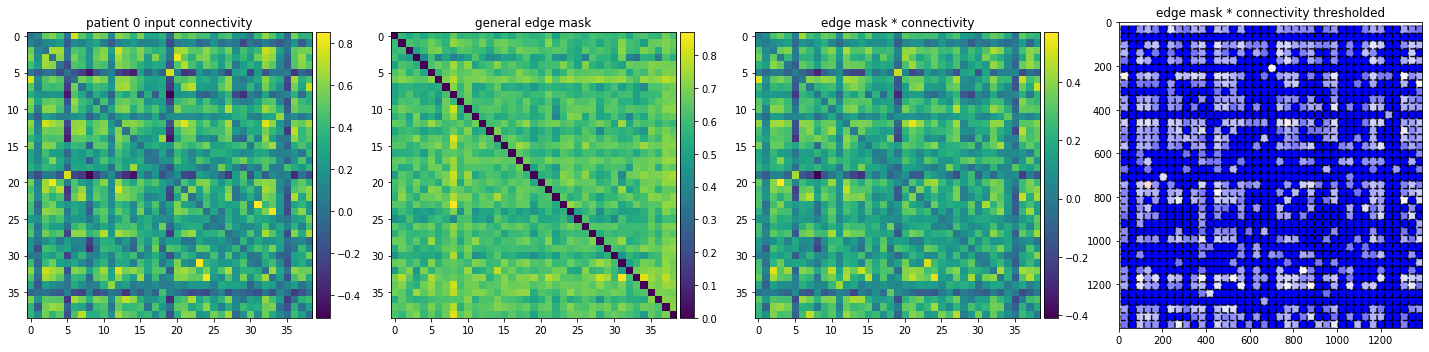

In [231]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, axs = plt.subplots(1, 4, figsize=(25, 25))

im0 = axs[0].imshow(connectivity_mat)
axs[0].set_title('patient 0 input connectivity')
divider = make_axes_locatable(axs[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im0, cax=cax, orientation='vertical');

im1 = axs[1].imshow(general_edge_mask)
axs[1].set_title('general edge mask')
divider = make_axes_locatable(axs[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical');


im2 = axs[2].imshow(general_edge_mask*connectivity_mat)
axs[2].set_title('edge mask * connectivity')
divider = make_axes_locatable(axs[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical');

axs[3].imshow(plt.imread('./IBGNN/fig/explained_Schiza_seed112078_negative_0_heatmap.png')[200:1600, 530:1920])
axs[3].set_title('edge mask * connectivity thresholded')



On the group level, we rank the most salient ROIs on the learned explanation mask by calculating the sum of the edge weights connected to each node. Then on the individual level, we use the BrainNet Viewer [37] to plot the salient ROIs on the average brain connectivity graph enhanced by the learned explanation mask.

In [198]:
# group level: to rank most salient ROIs on the explanation mask, 
#              we calculate the sum of the edge weights connected to each node.
print('group level ranking')
ranking = {}
for i, row in enumerate(connectivity_mat):
    ranking[list(names_map.keys())[i]] = sum(abs(row))
    
print(*enumerate(sorted(ranking.items(), key=lambda a: a[1])), sep='\n')

group level ranking
(0, ('L DMN', 4.412778685763514))
(1, ('R Post Temp', 4.564337984345163))
(2, ('R IPS', 6.619463691187773))
(3, ('R Ant IPS', 6.892999651541976))
(4, ('L Ant IPS', 7.043793708263952))
(5, ('Dors PCC', 7.060439531596601))
(6, ('L IPS', 7.681242379859503))
(7, ('Cereb', 8.620605851575464))
(8, ('Occ post', 8.732711710210413))
(9, ('Sup Front S', 8.925064758578195))
(10, ('R DMN', 9.677021735202844))
(11, ('R DLPFC', 9.931524799444018))
(12, ('Med DMN', 10.341535309358603))
(13, ('R Aud', 10.72997096642094))
(14, ('Cing', 10.745197488890485))
(15, ('Motor', 11.209664287056476))
(16, ('L Aud', 12.204024334656658))
(17, ('R TPJ', 12.583174568375098))
(18, ('R Ins', 13.414924095134708))
(19, ('Front DMN', 13.503590152916708))
(20, ('Vis', 13.607217158627662))
(21, ('L DLPFC', 13.900037617296844))
(22, ('Striate', 14.082956257819081))
(23, ('L Front pol', 14.189054328033833))
(24, ('L Par', 14.394006724431964))
(25, ('R Pars Op', 14.798776943725905))
(26, ('L LOC', 14.8599

### Illustrating ROIs

In [240]:
from nilearn.datasets import load_mni152_brain_mask
from nilearn.datasets import fetch_neurovault

In [235]:
mask_img = load_mni152_brain_mask()

/root/anaconda3/lib/python3.9/site-packages/nilearn/datasets/struct.py:378: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  warnings.warn("Default resolution of the MNI template will change "


In [241]:
# Download images
# Here by default we only download 80 images to save time,
# but for better results I recommend using at least 200.
print("Fetching Neurovault images; "
      "if you haven't downloaded any Neurovault data before "
      "this will take several minutes.")
nv_data = fetch_neurovault(max_images=30, fetch_neurosynth_words=True)

Fetching Neurovault images; if you haven't downloaded any Neurovault data before this will take several minutes.

Dataset created in /root/nilearn_data/neurovault

Reading local neurovault data.
No image found on local disk.
Reading server neurovault data.
Scroll collections: getting new batch: https://neurovault.org/api/collections/?limit=100&offset=0
Scroll collections: batch size: 100
Scroll images from collection 921: getting new batch: https://neurovault.org/api/collections/921/images/?limit=100&offset=0
Scroll images from collection 921: batch size: 1
On neurovault.org: no image matched query in collection 921
Scroll images from collection 440: getting new batch: https://neurovault.org/api/collections/440/images/?limit=100&offset=0
Scroll images from collection 440: batch size: 2
On neurovault.org: no image matched query in collection 440
Scroll images from collection 496: getting new batch: https://neurovault.org/api/collections/496/images/?limit=100&offset=0
Scroll images from 

Download succeeded, downloaded to: /root/nilearn_data/neurovault/collection_1257/neurosynth_words_for_image_17339.json
Already fetched 16 images
Download succeeded, downloaded to: /root/nilearn_data/neurovault/collection_1257/image_17340.nii.gz
Download succeeded, downloaded to: /root/nilearn_data/neurovault/collection_1257/neurosynth_words_for_image_17340.json
Already fetched 17 images
Download succeeded, downloaded to: /root/nilearn_data/neurovault/collection_1257/image_17341.nii.gz
Download succeeded, downloaded to: /root/nilearn_data/neurovault/collection_1257/neurosynth_words_for_image_17341.json
Already fetched 18 images
Download succeeded, downloaded to: /root/nilearn_data/neurovault/collection_1257/image_17342.nii.gz
Download succeeded, downloaded to: /root/nilearn_data/neurovault/collection_1257/neurosynth_words_for_image_17342.json
Already fetched 19 images
Download succeeded, downloaded to: /root/nilearn_data/neurovault/collection_1257/image_17343.nii.gz
Download succeeded, 

In [282]:
import nibabel as nib

In [285]:
nib.save(image.index_img(atlas_filename, 0), '_'.join(labels[0].split(' '))+'.nii')

/root/anaconda3/lib/python3.9/site-packages/numpy/ma/core.py:2826: UserWarning: Warning: converting a masked element to nan.
  _data = np.array(data, dtype=dtype, copy=copy,


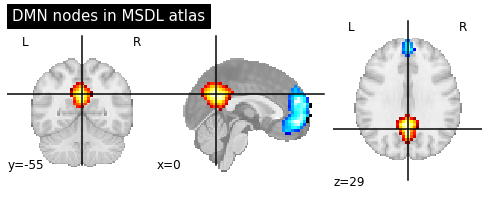

In [261]:
from nilearn import plotting, image

# First plot the map for the PCC: index 4 in the atlas
display = plotting.plot_stat_map(image.index_img(atlas_filename, 4),
                                 colorbar=False,
                                 title="DMN nodes in MSDL atlas")

# Now add as an overlay the maps for the ACC and the left and right
# parietal nodes
display.add_overlay(image.index_img(atlas_filename, 5),
                    cmap=plotting.cm.black_blue)
display.add_overlay(image.index_img(atlas_filename, 10),
                    cmap=plotting.cm.black_green)
# display.add_overlay(image.index_img(atlas_filename, 3),
#                     cmap=plotting.cm.black_pink)

plotting.show()

In [238]:


if term_weights is None:
    term_weights = np.ones((len(images), 2))
    vocabulary = np.asarray(
        ["Neurosynth is down", "Please try again later"])

# Clean and report term scores
term_weights[term_weights < 0] = 0
total_scores = np.mean(term_weights, axis=0)

print("\nTop 10 neurosynth terms from downloaded images:\n")

for term_idx in np.argsort(total_scores)[-10:][::-1]:
    print(vocabulary[term_idx])

/tmp/ipykernel_2446/573343062.py:1: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  mask_img.get_data().shape


(99, 117, 95)